
<style>
h1 { font-size: 2.0em; margin-top: 0.6em; margin-bottom: 0.4em; }
h2 { font-size: 1.6em; margin-top: 0.8em; margin-bottom: 0.3em; }
h3 { font-size: 1.25em; margin-top: 0.8em; margin-bottom: 0.3em; }
p, li { line-height: 1.55; }

.callout {
  border-left: 6px solid #bbb;
  background: #f7f7f7;
  padding: 0.8em 1em;
  border-radius: 6px;
  margin: 0.8em 0;
}
.callout.tip { border-color: #8bc34a; }
.callout.warn { border-color: #ff9800; }
.callout.info { border-color: #03a9f4; }

.toc {
  background: #fafafa;
  border: 1px solid #e5e5e5;
  border-radius: 8px;
  padding: 0.8em 1em;
}
hr.section-split { border: 0; border-top: 2px dashed #e0e0e0; margin: 1.2em 0; }
</style>



# 📘 Class 8 — Resampling Methods & Bootstrapping
**Data Science / Python Data Analysis**  
**Objective:** Understand and apply resampling (train/test split, k-fold cross-validation, bootstrap) to estimate model error and stability.

---

### 🧭 Quick navigation
- [📑 Table of Contents](#toc)
- [🧪 Hands‑on Practice](#practice)
- [🧠 Exercises](#exercises)
- [✅ Wrap‑Up](#wrapup)



## 📑 Table of Contents

- [1. 📚 Introduction to Resampling](#intro)
- [2. 🔁 K-Fold Cross-Validation](#kfold)
- [3. 🥾 Bootstrapping](#bootstrap)
- [4. 🧪 Hands‑on Practice](#practice)
- [5. 🧠 Exercises](#exercises)
- [6. ✅ Wrap‑Up](#wrapup)
- [⬆️ Back to Top](#top)



---
## **Importing Libraries**

In [13]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
from sklearn.utils import resample


---
<a id="bootstrap"></a>
<a id="bootstrap"></a>
## 🥾 **What is Bootstrapping?**

Bootstrapping is a powerful statistical technique used to estimate the distribution of a statistic (like the mean, median, variance, etc.) from a sample data set. It belongs to the broader class of resampling methods and is particularly useful when the theoretical distribution of the statistic is complex or unknown. The core idea behind bootstrapping is to generate many simulated samples from the original data, calculate the statistic of interest for each simulated sample, and then analyze the distribution of these statistics.

### **The Populations**

Two independent populations will be generated with the same mean but different distributions: one strongly left-skewed and the other with heavy tails. Two small samples are then taken (without replacement) from these populations and the performance of a t-test for equality of means is checked.

### **Data Generation**

First, we'll generate the datasets for each group. 

In [14]:
# Set seed for reproducibility
np.random.seed(0)

# Generate data
group1_initial = np.random.exponential(scale=1, size=1000)  # Exponential for left skew
group2_initial = np.random.standard_t(df=3, size=1000)      # t-distribution for heavy tails


To ensure both groups have the same mean, we'll adjust them accordingly after their initial generation.

In [15]:
# Adjust to have the same mean
mean_target = np.mean(np.concatenate((group1_initial, group2_initial)))  # Average mean of initial groups

group1 = group1_initial - np.mean(group1_initial) + mean_target
group2 = group2_initial - np.mean(group2_initial) + mean_target

# Check means
print(f'Group 1 Mean: {np.mean(group1)}')
print(f'Group 2 Mean: {np.mean(group2)}')


Group 1 Mean: 0.5244079967121674
Group 2 Mean: 0.5244079967121674


### **Visualizing the Distributions**

It's helpful to visualize the distributions of both groups to understand their shapes better.

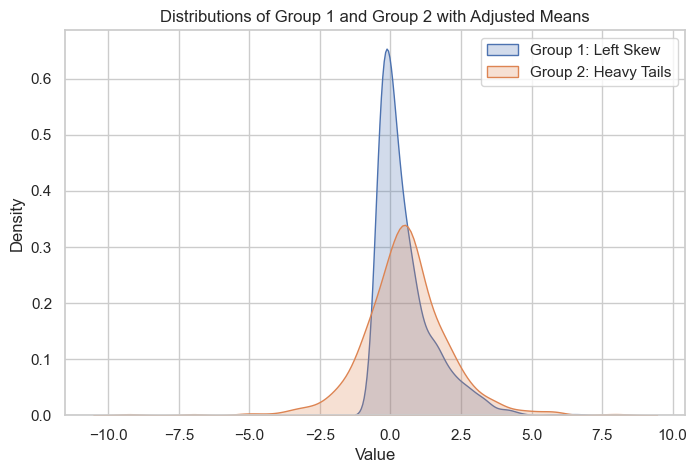

In [16]:
plt.figure(figsize=(8, 5))

# Plotting the distribution of Group 1: Left Skew using kdeplot
sns.kdeplot(group1, label='Group 1: Left Skew', fill=True)

# Plotting the distribution of Group 2: Heavy Tails using kdeplot
sns.kdeplot(group2, label='Group 2: Heavy Tails', fill=True)

plt.legend()
plt.title('Distributions of Group 1 and Group 2 with Adjusted Means')
plt.xlabel('Value')
plt.ylabel('Density')

plt.show()


### **Sampling from the Populations**

We will work with sample sizes of 30 for the first group and 35 for the second group.

The plot below shows the kernel density estimates for these smaller samples from each group. While these samples are drawn from distributions adjusted to have the same overall mean, the sample means might slightly differ due to sampling variability, especially with these smaller sample sizes.

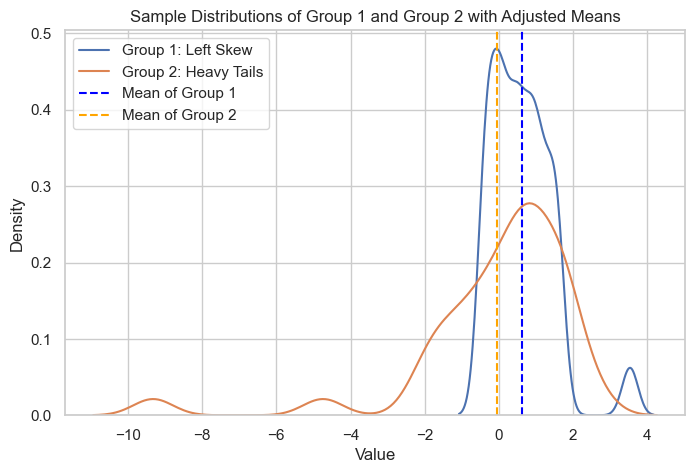

Group 1 Sample Mean: 0.625487270530838
Group 2 Sample Mean: -0.05074711421813244


In [17]:
np.random.seed(33)

# Adjusting the sample size to 30 for the first group and 35 for the second group

# Resample from the adjusted groups to get the new sample sizes
group1_sample = np.random.choice(group1, size=30, replace=False)
group2_sample = np.random.choice(group2, size=35, replace=False)

# New visualization using sns.kdeplot for kernel density estimation
plt.figure(figsize=(8, 5))

sns.kdeplot(group1_sample, label='Group 1: Left Skew', bw_adjust=0.5)
sns.kdeplot(group2_sample, label='Group 2: Heavy Tails', bw_adjust=0.5)

plt.axvline(np.mean(group1_sample), color='blue', linestyle='--', label='Mean of Group 1')
plt.axvline(np.mean(group2_sample), color='orange', linestyle='--', label='Mean of Group 2')

plt.legend()
plt.title('Sample Distributions of Group 1 and Group 2 with Adjusted Means')
plt.xlabel('Value')
plt.ylabel('Density')

plt.show()

# Return the mean of each sample to verify

print(f'Group 1 Sample Mean: {np.mean(group1_sample)}')
print(f'Group 2 Sample Mean: {np.mean(group2_sample)}')


### **$t-test$ for the Difference in Means**

In [18]:
# Perform a standard t-test for the difference in means between the two samples
t_stat, p_value = stats.ttest_ind(group1_sample, group2_sample, equal_var=False)

t_stat, p_value

print(f'The t-stat is equal to {t_stat:.2f}, with a p-value of {p_value:.4f} ')


The t-stat is equal to 1.69, with a p-value of 0.0983 


We can reject the null hypothesis at the 10% significance level, indicating there is a statistically significant difference in the means of the two samples. This result suggests that, despite the original populations having the same adjusted means, the samples drawn from these populations exhibit a significant difference in their means. This could be due to the small sample sizes and the specific characteristics of the distributions from which the samples were drawn (https://www.statology.org/t-test-assumptions/).

---
## **Bootstap Implementation**

<a id="bootstrap"></a>
<a id="bootstrap"></a>
### 🥾 **Bootstrapped $t-test$**

In [19]:
# Bootstrap Function

np.random.seed(55)

def bootstrap_mean_diff_corrected(x, y, n_bootstrap=50):
    """Calculate bootstrapped difference in means."""
    bootstrapped_diffs = []      #Here, an empty list bootstrapped_diffs is initialized
                                 #to store the differences in means from each bootstrap sample.
    for _ in range(n_bootstrap):
        sample_x = resample(x)
        sample_y = resample(y)
        diff = np.mean(sample_x) - np.mean(sample_y)
        bootstrapped_diffs.append(diff) #This diff is then appended to the list bootstrapped_diffs.
    return bootstrapped_diffs



We can now analyze the results of the bootstrap. The function `bootstrap_mean_diff_corrected` is called with group1_sample and group2_sample as inputs to generate the bootstrapped differences in means, `bootstrapped_diffs`.

In [20]:
# Perform bootstrap to get differences in means
bootstrapped_diffs_corrected = bootstrap_mean_diff_corrected(group1_sample, group2_sample)
print(bootstrapped_diffs_corrected)

[0.4218232947602675, 0.9919125830697885, 0.768137869252637, 0.21005439863145486, -0.10282076456806494, 0.7940119262628418, 0.7619327920143587, 0.363544382396805, 0.37519986176464154, 1.4945759402005225, 1.0138069385064459, 0.15662829997459643, 0.4663432391703582, 0.5919970695669199, 0.3625216894044333, 0.7707248503077607, 0.38939191231154924, 1.3091921663367556, 0.2546083546220559, 0.5212830830509015, 1.5754768573174545, 0.5025155154048645, 0.9278614028917189, 0.752259740519212, 1.1239820014445745, 0.32933200015066777, 1.3249568450651665, 0.4777459675837625, 0.32509345432160824, 0.24589841845694915, 0.12257496604929274, 1.3259701726411501, 0.7275364643461126, 0.9289648036390092, -0.03436572470930749, 0.23927180838273582, 0.31888517040328523, 0.5445364992458858, 1.6619842845548745, -0.15731383553528527, 1.0506226277693957, 0.43690421437892074, 1.152922300169343, -0.13672505481931163, 0.22403098870365287, 1.20497485860182, 0.7804935039080616, 0.7189606029902815, 0.41130345041853766, 0.90

<a id="bootstrap"></a>
<a id="bootstrap"></a>
### 🥾 **Calculate the Bootstrapped Standard Error and t-statistic**

In the following lines of code, we will compute the following objects:

* **Bootstrapped Standard Error** (`bootstrapped_se_corrected`): The standard deviation of the bootstrapped differences in means, which serves as an estimate of the standard error of the difference in means.

* **Observed Difference** (`observed_diff_corrected`): The actual difference in means between the two original samples (group1_sample and group2_sample).

* **T-statistic** (`t_stat_bootstrap_corrected`): The observed difference divided by the bootstrapped standard error, giving a measure of how many standard errors the observed difference is away from zero.

In [21]:
# Calculate the bootstrapped standard error and t-statistic
bootstrapped_se_corrected = np.std(bootstrapped_diffs_corrected, ddof=1)  # ddof=1 for sample standard deviation)
observed_diff_corrected = np.mean(group1_sample) - np.mean(group2_sample)
t_stat_bootstrap_corrected = observed_diff_corrected / bootstrapped_se_corrected

print(f'Bootstrap t-statistic: {t_stat_bootstrap_corrected:.3f}')

Bootstrap t-statistic: 1.494


**Note that we cannot use the "standard" t-distribution to obtain the p-value.** In traditional hypothesis testing, especially when dealing with small sample sizes, the p-value is often computed by comparing the calculated t-statistic against a t-distribution. This method assumes that the sampling distribution of the test statistic (under the null hypothesis) follows a specific distribution, which, for the t-test, is the t-distribution. This assumption allows you to determine how extreme the observed t-statistic is by comparing it to the theoretical distribution.

However, in the context of bootstrapping, the approach to computing the p-value is different and does not necessarily involve the t-distribution. This difference arises because bootstrapping is a non-parametric approach that does not rely on assumptions about the form of the population distribution from which the samples are drawn. Instead, it uses the **empirical distribution** obtained by repeatedly resampling the data to estimate the sampling distribution of a statistic.

The bootstrapped distribution of the test statistic (e.g., difference in means) allows for direct estimation of the p-value by calculating the proportion of bootstrapped statistics that are as extreme as or more extreme than the observed statistic. This approach does not require fitting the empirical results to any particular theoretical distribution.

### **p-value**

The p-value is estimated by calculating the proportion of the absolute bootstrapped differences that are greater than or equal to the absolute observed difference. This gives an idea of how extreme the observed difference is, considering the distribution of bootstrapped differences.

In [22]:

# Estimate the p-value using the bootstrapped differences
p_value_bootstrap_corrected = (np.sum(np.abs(bootstrapped_diffs_corrected) >= np.abs(observed_diff_corrected)) / len(bootstrapped_diffs_corrected))

print(f'Bootstrap t-statistic: {t_stat_bootstrap_corrected:.3f}, p-value: {p_value_bootstrap_corrected:.3f}')


Bootstrap t-statistic: 1.494, p-value: 0.460


Accordingly, we cannot reject the null hypothesis that the difference in means between the two groups is zero.

**Important Observation**:

Note that we divide the number of instances in which the bootstrapped absolute differences are greater than or equal to the absolute observed difference by the number of bootstraps repetitions:

* The logic behind this is to calculate the proportion of bootstrapped differences that are as extreme as, or more extreme than, the observed difference between the two samples. This proportion serves as an estimate of the p-value, which is a measure of the probability that the observed difference (or a more extreme difference) could occur by random chance if there were actually no difference between the populations from which the samples were drawn.

* The division by the length of bootstrapped_diffs_corrected is crucial because it turns a raw count into a proportion, making it interpretable as a probability value. This is consistent with the definition of a p-value in hypothesis testing, which is a probability measure, not a count.

---
## **The Empirical Distribution**

Bootstrap methods create an empirical distribution of the statistic of interest by resampling the data with replacement. This empirical distribution may or may not resemble a theoretical distribution like the t-distribution, especially if the underlying assumptions of the t-test (e.g., normality, equal variances) are not met.

Plotting the distribution of bootstrapped differences can provide insightful visualization into the variability and spread of the difference in means between two groups obtained through bootstrapping. 

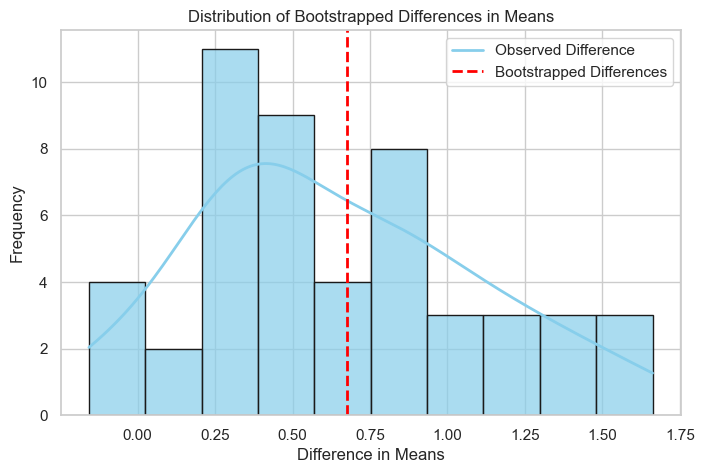

In [23]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))

# Plot histogram with KDE
sns.histplot(bootstrapped_diffs_corrected, bins=10, kde=True, edgecolor='k', color='skyblue', alpha=0.7,
             line_kws={'color': 'black', 'linewidth': 2})
plt.axvline(observed_diff_corrected, color='red', linestyle='dashed', linewidth=2)

plt.title('Distribution of Bootstrapped Differences in Means')
plt.xlabel('Difference in Means')
plt.ylabel('Frequency')
plt.legend(["Observed Difference", "Bootstrapped Differences"])
plt.show()


Finally, we can look at the descriptive statatistics of the bootstrapped differences.

In [25]:
from scipy.stats import skew

In [26]:

bootstrapped_diffs = np.array(bootstrapped_diffs_corrected)  # Ensure it's a numpy array for convenience

# Calculate basic descriptive statistics
mean = np.mean(bootstrapped_diffs)
median = np.median(bootstrapped_diffs)
std_dev = np.std(bootstrapped_diffs, ddof=1)  # ddof=1 for sample standard deviation
min_value = np.min(bootstrapped_diffs)
max_value = np.max(bootstrapped_diffs)
range_of_values = max_value - min_value

# Calculate skewness
skewness = skew(bootstrapped_diffs)

# Print the statistics
print(f'Mean: {mean}')
print(f'Median: {median}')
print(f'Standard Deviation: {std_dev}')
print(f'Min: {min_value}')
print(f'Max: {max_value}')
print(f'Range: {range_of_values}')
print(f'Skewness: {skewness}')


Mean: 0.638518939267847
Median: 0.5329097911483937
Standard Deviation: 0.45259034834774914
Min: -0.15731383553528527
Max: 1.6619842845548745
Range: 1.8192981200901597
Skewness: 0.3734823828541609



<a id="wrapup"></a>

## ✅ Wrap‑Up
- Resampling helps **estimate generalization error** and **model variability**.
- **K-Fold CV** reduces variance of the error estimate and is useful for comparing configurations.
- **Bootstrapping** quantifies uncertainty (confidence intervals, bias/variance).

<div class="callout tip">
<b>Next steps:</b> Try other sample sizes, different random seeds, and compare metrics (MAE, RMSE, R²).
</div>

[⬆️ Back to TOC](#toc) &nbsp; | &nbsp; [🔝 Top](#top)
